#### Análise das prinicipais margens em um mês específico (11/24)

In [ ]:
import requests
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

def ultimo_dia_mes(mes, ano):
    """
    Retorna o último dia do mês dado o número do mês e o ano com base em regras simples.

    :param mes: Número do mês (1 a 12)
    :param ano: Ano (ex: 2025)
    :return: Último dia do mês
    """
    if mes < 1 or mes > 12:
        raise ValueError("O mês deve estar entre 1 e 12.")

    if mes in {1, 3, 5, 7, 8, 10, 12}:  # Meses com 31 dias
        return 31
    elif mes in {4, 6, 9, 11}:  # Meses com 30 dias
        return 30
    else:  # Fevereiro
        return 29 if (ano % 4 == 0 and (ano % 100 != 0 or ano % 400 == 0)) else 28
    

# Função para extrair valores das contas específicas
def obter_valor_conta(cdata_root, conta_id):
    """
    Obtém o saldo final de uma conta específica pelo seu ID.

    :param cdata_root: Raiz do CDATA parseado.
    :param conta_id: ID da conta a ser buscada.
    :return: Saldo Final da conta (float) ou None se não encontrado.
    """
    for item in cdata_root.findall(".//SDT_SaldoContabilItem"):
        if item.find("ContaIDNivel").text == conta_id:
            saldo_inicial = item.find("SaldoInicial").text
            saldo_final = item.find("SaldoFinal").text
            return np.round(float(saldo_final) - float(saldo_inicial), 2)
    return None
    

# escolhendo o mes e o ano da consulta

def analise_margens_subsetores_mes(mes, ano):
    ultimo_dia = ultimo_dia_mes(mes, ano)
    # URL do serviço SOAP
    url = "https://gaivota.dealernetworkflow.com.br/aws_dealernetgateway.aspx"

    # Cabeçalhos HTTP
    headers = {
        "Content-Type": "text/xml; charset=utf-8",
    }

    # Corpo da requisição SOAP
    soap_body = f"""
    <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:deal="DealerNet">
    <soapenv:Header/>
    <soapenv:Body>
        <deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
            <deal:Usuario_identificador>portus</deal:Usuario_identificador>
            <deal:Usuariosenha_senha>Portus25@</deal:Usuariosenha_senha>
            <deal:Empresa_codigo>1</deal:Empresa_codigo>
            <deal:Dtini>{ano}-{mes:02d}-01</deal:Dtini>
            <deal:Dtfin>{ano}-{mes:02d}-{ultimo_dia}</deal:Dtfin>
        </deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
    </soapenv:Body>
    </soapenv:Envelope>
    """

    # Fazer a requisição SOAP
    response = requests.post(url, data=soap_body, headers=headers)

    # Verificar se a resposta é válida
    if response.status_code == 200:
        # Parsear o XML da resposta
        root = ET.fromstring(response.content)

        # Namespaces do XML
        namespaces = {
            "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
            "deal": "DealerNet",
        }

        # Localizar o CDATA com os dados de contas
        body = root.find("soapenv:Body", namespaces)
        response = body.find("deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse", namespaces)
        xml_retorno = response.find("deal:Xml_retorno", namespaces)

        # Parse do CDATA
        if xml_retorno is not None and xml_retorno.text:
            cdata_content = xml_retorno.text.strip()
            cdata_root = ET.fromstring(cdata_content)

            # Lista de contas para calcular as métricas
            contas = [
                {"nome": "VN Passageiros", "receita": "3.1.1.001.000001", "custo": "3.3.1.001.000001"},
                {"nome": "VN Comerciais Leves", "receita": "3.1.1.001.000002", "custo": "3.3.1.001.000002"},
                {"nome": "Seminovos", "receita": "3.1.1.002.000001", "custo": "3.3.1.002.000001"},
                {"nome": "Peças Atacado", "receita": "3.1.1.003.000001", "custo": "3.3.1.003.000001"},
                {"nome": "Peças Varejo", "receita": "3.1.1.003.000002", "custo": "3.3.1.003.000002"},
                {"nome": "Peças Mecânica", "receita": "3.1.1.003.000003", "custo": "3.3.1.003.000003"},
                {"nome": "Peças Funilaria e Pintura", "receita": "3.1.1.003.000004", "custo": "3.3.1.003.000004"},
                {"nome": "Peças Garantia", "receita": "3.1.1.003.000005", "custo": "3.3.1.003.000005"},
                {"nome": "Peças Interna", "receita": "3.1.1.003.000006", "custo": "3.3.1.003.000006"},
                {"nome": "Acessórios", "receita": "3.1.1.003.000007", "custo": "3.3.1.003.000007"},
                {"nome": "Combustíveis e Lubrificantes", "receita": "3.1.1.003.000008", "custo": "3.3.1.003.000008"},
                {"nome": "Pneus e Câmaras", "receita": "3.1.1.003.000009", "custo": "3.3.1.003.000009"},
            ]

            # Armazenar os resultados
            nomes = []
            resultados = []
            margens = []

            for conta in contas:
                valor_receita = obter_valor_conta(cdata_root, conta["receita"])
                valor_custo = obter_valor_conta(cdata_root, conta["custo"])

                if valor_receita is not None and valor_custo is not None:
                    resultado = -valor_receita - valor_custo
                    margem = -resultado / valor_receita * 100
                    nomes.append(conta["nome"])
                    resultados.append(resultado / 1000)  # Convertendo para milhares de reais
                    margens.append(margem)
                else:
                    print(f"Erro: Não foi possível calcular para {conta['nome']}.")

            # Criar o gráfico
            fig, ax1 = plt.subplots(figsize=(12, 6))

            # Gráfico de barras para os resultados
            ax1.bar(nomes, resultados, color='DodgerBlue', label='Resultado (mil R$)')
            ax1.set_ylabel('Resultado (mil R$)')
            ax1.tick_params(axis='y')
            ax1.set_xticklabels(nomes, rotation=45, ha='right')

            # Adicionar legenda ao gráfico de barras
            ax1.legend(loc='upper right')#, bbox_to_anchor=(0.0, 1.1))

            # Gráfico de linha para as margens
            ax2 = ax1.twinx()
            ax2.plot(nomes, margens, color='OrangeRed', marker='o', label='Margem Bruta (%)')
            ax2.set_ylabel('Margem Bruta (%)')
            ax2.tick_params(axis='y')

            # Adicionar legenda ao gráfico de linha
            ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.92))

            # Título e legendas
            plt.title('Resultados e Margens Brutas em por Subsetores')
            fig.tight_layout()
            plt.show()

        else:
            print("Erro: Não foi possível localizar o CDATA com os dados.")
    else:
        print(f"Erro na requisição: {response.status_code}")
        print(response.text)
    
    return


C:\Users\bruno\AppData\Local\Temp\ipykernel_5664\3632659001.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nomes, rotation=45, ha='right')


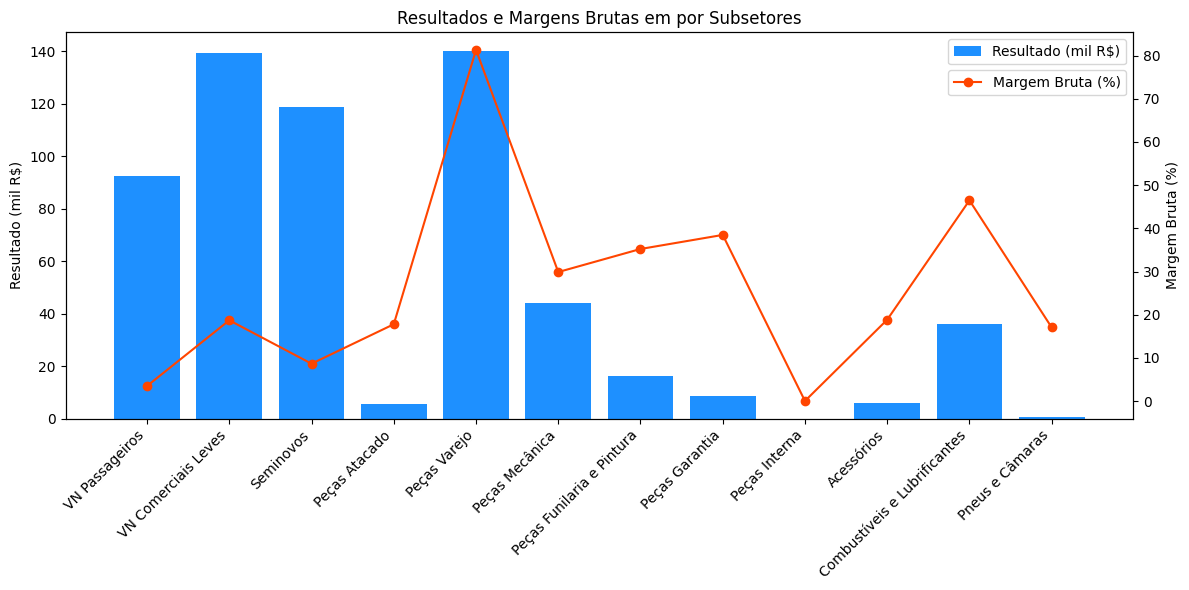

In [ ]:
analise_margens_subsetores_mes(11, 2024)

In [ ]:
def analise_margens_setores_mes(mes, ano):
    ultimo_dia = ultimo_dia_mes(mes, ano)
    # URL do serviço SOAP
    url = "https://gaivota.dealernetworkflow.com.br/aws_dealernetgateway.aspx"

    # Cabeçalhos HTTP
    headers = {
        "Content-Type": "text/xml; charset=utf-8",
    }

    # Corpo da requisição SOAP
    soap_body = f"""
    <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:deal="DealerNet">
    <soapenv:Header/>
    <soapenv:Body>
        <deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
            <deal:Usuario_identificador>portus</deal:Usuario_identificador>
            <deal:Usuariosenha_senha>Portus25@</deal:Usuariosenha_senha>
            <deal:Empresa_codigo>1</deal:Empresa_codigo>
            <deal:Dtini>{ano}-{mes:02d}-01</deal:Dtini>
            <deal:Dtfin>{ano}-{mes:02d}-{ultimo_dia}</deal:Dtfin>
        </deal:WS_DealernetGateway.CONSULTASALDOCONTABIL>
    </soapenv:Body>
    </soapenv:Envelope>
    """

    # Fazer a requisição SOAP
    response = requests.post(url, data=soap_body, headers=headers)

    # Verificar se a resposta é válida
    if response.status_code == 200:
        # Parsear o XML da resposta
        root = ET.fromstring(response.content)

        # Namespaces do XML
        namespaces = {
            "soapenv": "http://schemas.xmlsoap.org/soap/envelope/",
            "deal": "DealerNet",
        }

        # Localizar o CDATA com os dados de contas
        body = root.find("soapenv:Body", namespaces)
        response = body.find("deal:WS_DealernetGateway.CONSULTASALDOCONTABILResponse", namespaces)
        xml_retorno = response.find("deal:Xml_retorno", namespaces)

        # Parse do CDATA
        if xml_retorno is not None and xml_retorno.text:
            cdata_content = xml_retorno.text.strip()
            cdata_root = ET.fromstring(cdata_content)

            # Lista de contas para calcular as métricas
            contas = [
                {"nome": "VN Passageiros", "receita": "3.1.1.001.000001", "custo": "3.3.1.001.000001"},
                {"nome": "VN Comerciais Leves", "receita": "3.1.1.001.000002", "custo": "3.3.1.001.000002"},
                {"nome": "Seminovos", "receita": "3.1.1.002.000001", "custo": "3.3.1.002.000001"},
                {"nome": "Peças Atacado", "receita": "3.1.1.003.000001", "custo": "3.3.1.003.000001"},
                {"nome": "Peças Varejo", "receita": "3.1.1.003.000002", "custo": "3.3.1.003.000002"},
                {"nome": "Peças Mecânica", "receita": "3.1.1.003.000003", "custo": "3.3.1.003.000003"},
                {"nome": "Peças Funilaria e Pintura", "receita": "3.1.1.003.000004", "custo": "3.3.1.003.000004"},
                {"nome": "Peças Garantia", "receita": "3.1.1.003.000005", "custo": "3.3.1.003.000005"},
                {"nome": "Peças Interna", "receita": "3.1.1.003.000006", "custo": "3.3.1.003.000006"},
                {"nome": "Acessórios", "receita": "3.1.1.003.000007", "custo": "3.3.1.003.000007"},
                {"nome": "Combustíveis e Lubrificantes", "receita": "3.1.1.003.000008", "custo": "3.3.1.003.000008"},
                {"nome": "Pneus e Câmaras", "receita": "3.1.1.003.000009", "custo": "3.3.1.003.000009"},
            ]

    # Consolidar setores (Vendas e Pós-Vendas)
    setores = {
        "Vendas": [
            {"nome": "VN Passageiros", "receita": "3.1.1.001.000001", "custo": "3.3.1.001.000001"},
            {"nome": "VN Comerciais Leves", "receita": "3.1.1.001.000002", "custo": "3.3.1.001.000002"},
        ],
        "Pós-Vendas": [
            {"nome": "Seminovos", "receita": "3.1.1.002.000001", "custo": "3.3.1.002.000001"},
            {"nome": "Peças Atacado", "receita": "3.1.1.003.000001", "custo": "3.3.1.003.000001"},
            {"nome": "Peças Varejo", "receita": "3.1.1.003.000002", "custo": "3.3.1.003.000002"},
            {"nome": "Peças Mecânica", "receita": "3.1.1.003.000003", "custo": "3.3.1.003.000003"},
            {"nome": "Peças Funilaria e Pintura", "receita": "3.1.1.003.000004", "custo": "3.3.1.003.000004"},
            {"nome": "Peças Garantia", "receita": "3.1.1.003.000005", "custo": "3.3.1.003.000005"},
            {"nome": "Peças Interna", "receita": "3.1.1.003.000006", "custo": "3.3.1.003.000006"},
            {"nome": "Acessórios", "receita": "3.1.1.003.000007", "custo": "3.3.1.003.000007"},
            {"nome": "Combustíveis e Lubrificantes", "receita": "3.1.1.003.000008", "custo": "3.3.1.003.000008"},
            {"nome": "Pneus e Câmaras", "receita": "3.1.1.003.000009", "custo": "3.3.1.003.000009"},
        ],
    }

    # Armazenar resultados consolidados
    nomes_setores = []
    resultados_setores = []
    margens_setores = []

    for setor, contas in setores.items():
        receita_total = 0
        custo_total = 0

        for conta in contas:
            valor_receita = obter_valor_conta(cdata_root, conta["receita"])
            valor_custo = obter_valor_conta(cdata_root, conta["custo"])

            if valor_receita is not None and valor_custo is not None:
                receita_total += valor_receita
                custo_total += valor_custo
            else:
                print(f"Erro: Não foi possível calcular para {conta['nome']} no setor {setor}.")

        # Calcular resultado e margem do setor
        resultado_setor = -receita_total - custo_total
        margem_setor = -resultado_setor / receita_total * 100 if receita_total != 0 else 0

        nomes_setores.append(setor)
        resultados_setores.append(resultado_setor / 1000)  # Convertendo para milhares de reais
        margens_setores.append(margem_setor)

    # Criar o gráfico consolidado
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Gráfico de barras para os resultados consolidados
    ax1.bar(nomes_setores, resultados_setores, color='DodgerBlue', label='Resultado (mil R$)')
    ax1.set_ylabel('Resultado (mil R$)')
    ax1.tick_params(axis='y')

    # Gráfico de linha para as margens consolidadas
    ax2 = ax1.twinx()
    ax2.plot(nomes_setores, margens_setores, color='OrangeRed', marker='o', label='Margem Bruta (%)')
    ax2.set_ylabel('Margem Bruta (%)')
    ax2.tick_params(axis='y')

    ax1.legend(loc='upper left')#, bbox_to_anchor=(0.0, 1.1))
    ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.92))

    # Título e ajustes finais
    plt.title(f'Resultados e Margens Brutas por Setor - {mes:02d}/{ano}')
    fig.tight_layout()
    plt.show()

    return


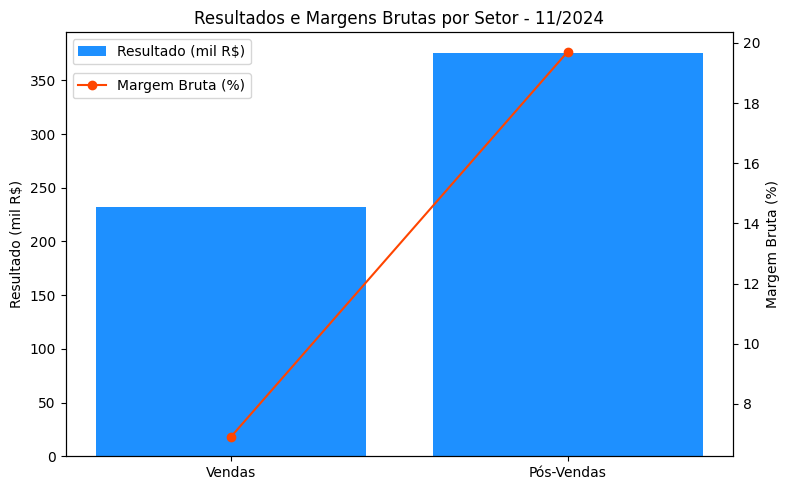

In [23]:
analise_margens_setores_mes(11,2024)